# Retail Distribution and Street Network Centrality in King’s Cross, London

## 1.Introduction

**King’s Cross** combines historic high streets with newly developed retail destinations. Traditional retail is often associated with highly accessible and movement-intensive streets, whereas destination-oriented retail may not depend strongly on network centrality.

This study compares **closeness and betweenness centrality** with retail locations across King’s Cross to examine whether retail concentration reflects **movement accessibility** or **destination-oriented** clustering.

## 2. Dataset and neighbourhood succinctly

The study area is a 2,000 m radius around King’s Cross, London, including historic streets and the Coal Drops Yard redevelopment. A pedestrian street network is extracted from OpenStreetMap using OSMnx with a 2,500 m buffer to reduce edge effects. Retail locations are obtained from OpenStreetMap amenities and shops, providing a consistent dataset for comparing retail distribution with network structure.


### 3.1 Environment set

In [52]:
import matplotlib
import numpy as np    # data analysis and manipulation tool
import matplotlib.pyplot as plt    # data visualization library
import matplotlib.cm as cm    # colormap library for visualizations
import matplotlib.colors as colors    # color normalization for visualizations
import pandas as pd    # data manipulation and analysis library
import osmnx as ox    # library for working with OpenStreetMap data
import networkx as nx    # library for working with graphs and networks
import geopandas as gpd    # library for working with geospatial data
import contextily as ctx    # library for adding basemaps to geospatial data

### 3.2 AOI Definition & Build Network

In [20]:
# -- Set AOI (Area of Interest) --
place_name = "King's Cross, London, UK"

radius_m = 2000  # radius in meters
buffer_m = 2500  # buffer distance in meters

network_type = 'walk'  # type of network to retrieve (e.g., 'walk', 'drive', 'bike')


# -- Get Certain AOI Coordinates --
def get_aoi_coordinates(place_name):
    """
    Return the latitude and longitude of a place using OSMnx geocoding.

    A place name or address recognised by OpenStreetMap/Nominatim 

    Returns
    tuple (lat, lon)
    Geographic coordinates in WGS84 (EPSG:4326).
    """
    # Get the geocode for the specified place
    geocode = ox.geocode(place_name)
    return geocode

center_lat, center_lon = get_aoi_coordinates(place_name)
print(f"Center coordinates of {place_name}: Latitude = {center_lat}, Longitude = {center_lon}")

Center coordinates of King's Cross, London, UK: Latitude = 51.5323954, Longitude = -0.1230224


In [21]:
# -- Download the street network for the specified place and network type --
G = ox.graph_from_point(
    (center_lat, center_lon),
    dist=buffer_m,
    network_type = network_type,
    simplify=True
)


In [22]:
# Keep only the largest connected component
try:
    # prefer osmnx helper if available
    G = ox.utils_graph.get_largest_component(G, strongly=False)
except Exception:
    # fallback using networkx
    if G.is_directed():
        G_und = G.to_undirected()
    else:
        G_und = G
    largest_cc = max(nx.connected_components(G_und), key=len)
    G = G.subgraph(largest_cc).copy()


In [23]:
# -- project the graph to the local projected CRS for accurate distance calculations --
G_projected = ox.project_graph(G) 

In [153]:
# -- Network Map --
#fig, ax = ox.plot_graph(  # plot the graph
#    G_projected,
#   figsize=(12, 12),
#    node_size=0,
#    edge_color='white',  # edge color
#    edge_linewidth=0.7,
#)

In [ ]:
# -- Truncate the graph to a 2km buffer around the center point --
center_node = ox.nearest_nodes(G_projected, center_lon, center_lat)


In [26]:
print(center_lat, center_lon)
print(center_node)


51.5323954 -0.1230224
12379276442


In [ ]:
# -- Distinguish research zone and buffer zone --
# The network was downloaded with a 2.5 km buffer to mitigate edge effects.
# The analysis focuses on the 2 km study area defined by network distance from the study centre.
from shapely.geometry import Point  # for creating point geometries

G_2km = ox.truncate.truncate_graph_dist(  # truncate the graph to a 2km radius around the source node
    G_projected,
    source_node = center_node,
    dist=radius_m,
    weight="length",
)


In [28]:
# -- Verify basic information --
# Print the number of nodes in the original projected graph and the truncated 2km graph
print("Buffered network nodes:", len(G_projected.nodes))
print("2km network nodes:", len(G_2km.nodes))

# Calculate the shortest path lengths from the center node to all other nodes in the projected graph
# This will help us verify that the truncation to 2km is working correctly by checking the maximum distance in the truncated graph.
lengths_2km = nx.single_source_dijkstra_path_length(
    G_projected,
    center_node,
    weight="length"
)
 
max_dist_2km = max(
    d for node, d in lengths_2km.items() 
    if node in G_2km.nodes
)

print("Max walking distance in 2km network:", round(max_dist_2km))

# Check if the center node is in the truncated 2km graph
print("Center node in 2km network:", center_node in G_2km.nodes)


Buffered network nodes: 20962
2km network nodes: 2883
Max walking distance in 2km network: 2000
Center node in 2km network: True


### 3.3 Calculate Centrality (Closeness & Betweenness)

In [69]:
print("2km Walking Network")
print("Nodes:", G_2km.number_of_nodes())
print("Edges:", G_2km.number_of_edges())

2km Walking Network
Nodes: 2883
Edges: 7630


In [ ]:
# -- Convert walking network to DiGraph for centrality analysis --
# Convert MultiDiGraph to DiGraph to remove parallel edges 
# and simplify the network structure for centrality analysis
DG_walk = ox.convert.to_digraph(G_2km)

# -- Closeness centrality (edge-based) --
# Use line graph representation so that street segments are treated as nodes
# This allows edge-based centrality analysis to be performed using standard node-based centrality functions.
edge_cc = nx.closeness_centrality(
    nx.line_graph(DG_walk),
    distance="length"
)

nx.set_edge_attributes(DG_walk, edge_cc, 'cc')  # store closeness centrality values as edge attributes in the original graph

# -- Betweenness centrality (edge-based) --
edge_bc = nx.betweenness_centrality(
    nx.line_graph(DG_walk),
    weight="length"      # keep real walking distance
)

nx.set_edge_attributes(DG_walk, edge_bc, 'bc') #  store betweenness centrality values as edge attributes in the original graph


# -- Degree centrality (edge-based) --
edge_dc = nx.degree_centrality(
    nx.line_graph(DG_walk)
)

nx.set_edge_attributes(DG_walk, edge_dc, 'dc')


# -- Convert back to MultiGraph for plotting --
G_walk_multi = nx.MultiGraph(DG_walk)

In [156]:
# -- Visualize edge closeness centrality --

#nc = ox.plot.get_edge_colors_by_attr(
#    G_walk_multi,
#    'cc',
 #   cmap='plasma'
#)

#fig, ax = ox.plot_graph(
#    G_walk_multi,
#    node_size=0,
#    node_color='w',
#    node_edgecolor='gray',
 #   node_zorder=2,
 #   edge_color=nc,
 #   edge_linewidth=1.5,
#    edge_alpha=1
#)

# add basemap
# 
#ax.set_title("Edge Closeness Centrality (2km Walk Network)")

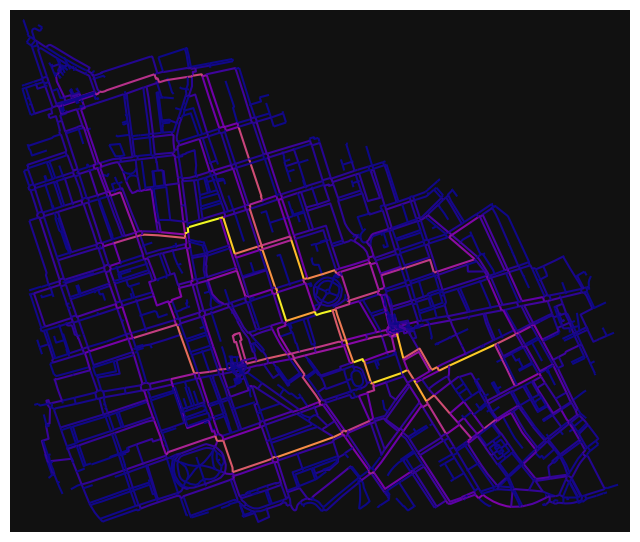

In [191]:
# -- Visualize edge betweenness centrality --

nc = ox.plot.get_edge_colors_by_attr(
    G_walk_multi,
    'bc',
    cmap='plasma'
)

fig, ax = ox.plot_graph(
    G_walk_multi,
    node_size=0,
    node_color='w',
    node_edgecolor='gray',
    node_zorder=2,
    edge_color=nc,
    edge_linewidth=1.5,
    edge_alpha=1
)

ax.set_title("Edge Betweenness Centrality (2km Walk Network)")

plt.show()

#### This map establishes the movement structure used to evaluate retail alignment with pedestrian flow.

### 3.4 Download Retail data (Shop & Cafe & Restaurant)

In [89]:
# -- define retail tags --

tags = {
    'shop': True,  # all types of shops
    'amenity': ["restaurant", "cafe"]
}

In [90]:
# --Convert network edges to GeoDataFrame for spatial analysis and visualization --
nodes, edges = ox.graph_to_gdfs(G_2km)

# -- Create convex hull polygon for study area --
study_area = edges.union_all().convex_hull

In [94]:
# -- Download retail POIs within study area --
study_area_wgs = gpd.GeoSeries(
    [study_area], 
    crs=G_2km.graph["crs"]
    ).to_crs("EPSG:4326").iloc[0]

retail = ox.features_from_polygon(
    study_area_wgs,
    tags
)

In [98]:
# -- Convert all geometries to point (use centroid) --
retail["geometry"] = retail.geometry.centroid

# -- Project retail to network CRS --
retail = retail.to_crs(G_2km.graph["crs"])

print("Total retail points:", len(retail))

Total retail points: 2258


C:\Users\78561\AppData\Local\Temp\ipykernel_25664\367005892.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  retail["geometry"] = retail.geometry.centroid


### 3.5 Retail over Betweeness

In [99]:
# Check the CRS of the network and retail data to ensure they match for spatial analysis
print(G_walk_multi.graph["crs"])
print(retail.crs)

EPSG:32630
EPSG:32630


In [167]:
# Get edge colors by betweenness
edge_colors = ox.plot.get_edge_colors_by_attr(
    G_walk_multi,
    "bc",
    cmap="plasma"
)

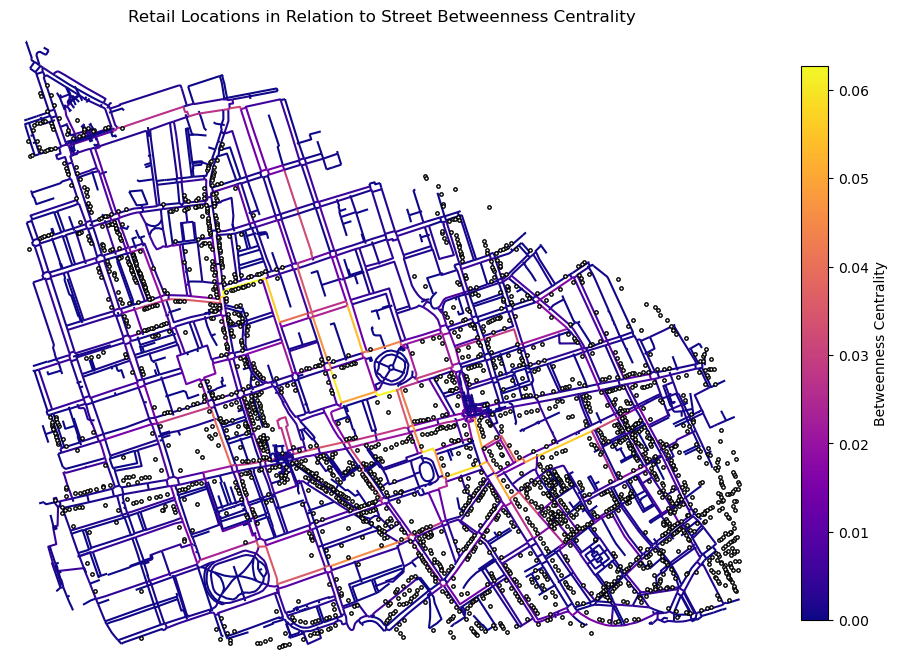

In [168]:

fig, ax = ox.plot_graph(
    G_walk_multi,
    figsize=(12, 12),
    node_size=0,
    node_color= "black",
    edge_color=edge_colors,
    edge_linewidth=1.5,
    bgcolor="white",
    show=False,
    close=False
)

retail.plot(
    ax=ax,
    facecolor= "white",
    edgecolor="black",
    markersize=6,
    alpha=1
)

ax.set_title("Retail Locations in Relation to Street Betweenness Centrality")

# Add colorbar for edge betweenness centrality
edge_vals = [data["bc"] for u,v,k,data in G_walk_multi.edges(keys=True, data=True)]
norm = colors.Normalize(vmin=min(edge_vals), vmax=max(edge_vals))
sm = cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, shrink=0.6, label="Betweenness Centrality", orientation= "vertical")

plt.show()

#### This figure tests whether retail locations correspond to high-movement corridors.

In [ ]:
# -- Download retail POIs within study area --
study_area_wgs = gpd.GeoSeries(
    [study_area], 
    crs=G_2km.graph["crs"]
    ).to_crs("EPSG:4326").iloc[0]

retail = ox.features_from_polygon(
    study_area_wgs,
    tags
)

### 3.6 Retail over Closeness

In [170]:
# Get edge colors by betweenness
edge_colors = ox.plot.get_edge_colors_by_attr(
    G_walk_multi,
    "cc",
    cmap="plasma"
)

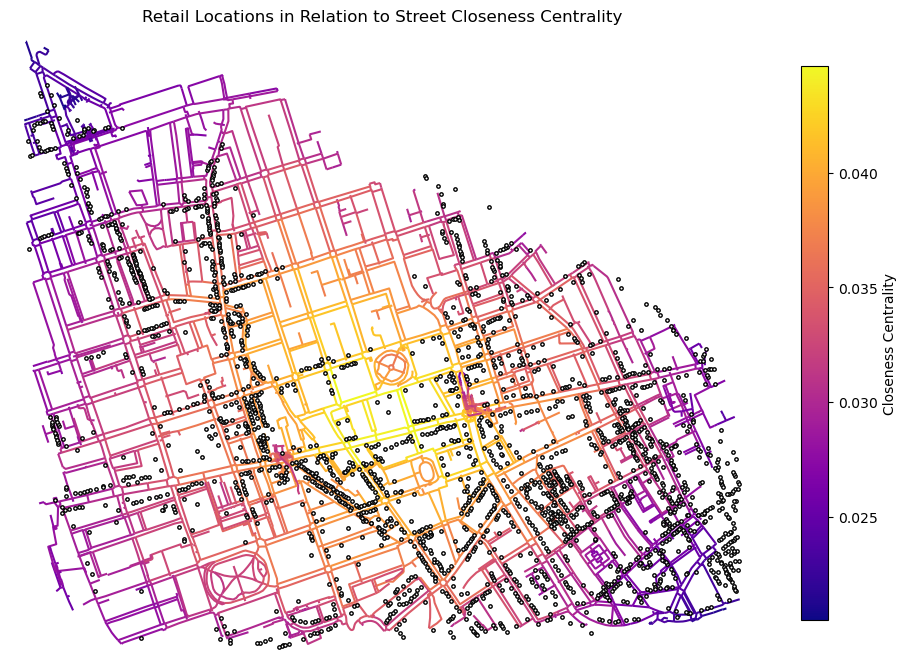

In [172]:
fig, ax = ox.plot_graph(
    G_walk_multi,
    figsize=(12, 12),
    node_size=0,
    node_color= "black",
    edge_color=edge_colors,
    edge_linewidth=1.5,
    bgcolor="white",
    show=False,
    close=False
)

retail.plot(
    ax=ax,
    facecolor= "white",
    edgecolor="black",
    markersize=6,
    alpha=1
)

ax.set_title("Retail Locations in Relation to Street Closeness Centrality")

# Add colorbar for edge closeness centrality
edge_vals = [data["cc"] for u,v,k,data in G_walk_multi.edges(keys=True, data=True)]
norm = colors.Normalize(vmin=min(edge_vals), vmax=max(edge_vals))
sm = cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, shrink=0.6, label="Closeness Centrality", orientation= "vertical")

plt.show()

#### This figure assesses whether retail distribution relates to overall network accessibility.

In [173]:
# All street betweenness
all_bc = [
    data["bc"]
    for u, v, k, data in G_walk_multi.edges(keys=True, data=True)
]

# All street closeness
all_cc = [
    data["cc"]
    for u, v, k, data in G_walk_multi.edges(keys=True, data=True)
]



C:\Users\78561\AppData\Local\Temp\ipykernel_25664\3985722767.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


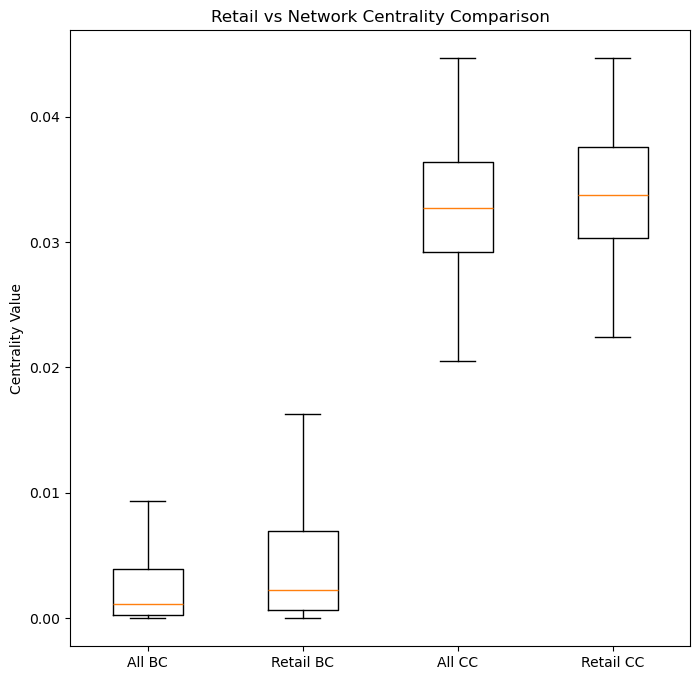

In [179]:

plt.figure(figsize=(8,8))

plt.boxplot(
    [all_bc, retail["bc"], all_cc, retail["cc"]],
    labels=["All BC", "Retail BC", "All CC", "Retail CC"],
    showfliers=False
)

plt.title("Retail vs Network Centrality Comparison")
plt.ylabel("Centrality Value")

plt.show()

#### This plot determines which centrality measure better explains retail location patterns.

## 4. Discussion

In [184]:
# Calculate and print summary statistics for betweenness and closeness centrality for all streets and retail streets
print("----- Betweenness Centrality -----")
print("All Streets:")
print("Mean:", np.mean(all_bc))
print("Median:", np.median(all_bc))
print("Std:", np.std(all_bc))

print("\nRetail Streets:")
print("Mean:", np.mean(retail["bc"]))
print("Median:", np.median(retail["bc"]))
print("Std:", np.std(retail["bc"]))


print("\n----- Closeness Centrality -----")
print("All Streets:")
print("Mean:", np.mean(all_cc))
print("Median:", np.median(all_cc))
print("Std:", np.std(all_cc))

print("\nRetail Streets:")
print("Mean:", np.mean(retail["cc"]))
print("Median:", np.median(retail["cc"]))
print("Std:", np.std(retail["cc"]))

----- Betweenness Centrality -----
All Streets:
Mean: 0.00397353248264209
Median: 0.001147729530083861
Std: 0.007599007820326595

Retail Streets:
Mean: 0.005879645237999554
Median: 0.0022851422184954296
Std: 0.009536880532328516

----- Closeness Centrality -----
All Streets:
Mean: 0.032824912427912606
Median: 0.03268687580878844
Std: 0.005030418042483128

Retail Streets:
Mean: 0.03370173768862468
Median: 0.03375601112680515
Std: 0.0050167935116279625


In [185]:
# Calculate and print the relative increase in mean centrality for retail streets compared to all streets
print("\n----- Relative Increase -----")

bc_increase = (np.mean(retail["bc"]) - np.mean(all_bc)) / np.mean(all_bc)
cc_increase = (np.mean(retail["cc"]) - np.mean(all_cc)) / np.mean(all_cc)

print("Retail BC increase (%):", bc_increase * 100)
print("Retail CC increase (%):", cc_increase * 100)


----- Relative Increase -----
Retail BC increase (%): 47.97023212177312
Retail CC increase (%): 2.6712188879031644


The stronger relative increase in **betweenness** suggests that retail streets are disproportionately located along **movement-intensive corridors.** 

In contrast, the *smaller difference in closeness* indicates that overall network accessibility plays a secondary role. This pattern implies that retail concentration in King’s Cross remains structurally embedded within **pedestrian flow** rather than being spatially independent of the network. While redevelopment may enhance the attractiveness of specific areas, the underlying movement configuration continues to shape retail distribution. Therefore, retail clustering appears more movement-oriented than purely destination-driven.

##### Retail in King’s Cross is more strongly associated with movement accessibility than with overall network accessibility.

In [3]:
import os
print(os.getcwd())

c:\Users\78561\GEOG0051\Week5
